# Import pakages

In [64]:
import time
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,precision_score,recall_score,auc,roc_curve
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm, linear_model, naive_bayes, ensemble, neural_network
import nltk
import warnings
warnings.filterwarnings("ignore")

# Loading data

In [65]:
TrainData=pd.read_csv("train.csv")
TestData=pd.read_csv("train.csv")
EvaData=pd.read_csv("evaluation.csv")

# Overview of data and visualization

In [66]:
TrainData.head(3)

,score,text
0,0,"overgeneralized, not helpful to anyone serious..."
1,1,Great sound and service.
2,1,love this book!!!: this book is a fast read ab...


In [67]:
pd.value_counts(TrainData['score'])   ###Aim: Confirm if the datasets have big difference between each other

1    3752
0    3748
Name: score, dtype: int64

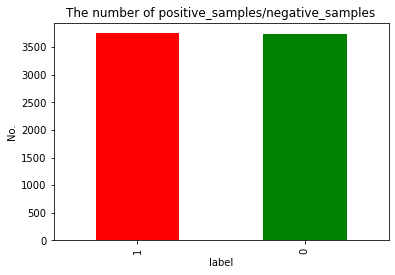

In [68]:
pd.value_counts(TrainData['score'], sort=True).plot(kind='bar',color=['r', 'g'])  
plt.title('The number of positive_samples/negative_samples')  
plt.xlabel('label') 
plt.ylabel('No.')
plt.show() #show the figure

In [69]:
TrainData.head(10)

,score,text
0,0,"overgeneralized, not helpful to anyone serious..."
1,1,Great sound and service.
2,1,love this book!!!: this book is a fast read ab...
3,1,A hugely enjoyable screen version of Rona Jaff...
4,0,What an uninteresting hodge-podge. It could ha...
5,1,@USAirways customer service at its best! Rache...
6,0,@VirginAmerica Is it normal to receive no repl...
7,0,Imagine the worst skits from Saturday Night Li...
8,0,This is one of the worst films ever. I like ch...
9,1,@JetBlue flight attendant Wendi on Flt 127 on ...


# Data classification

In [70]:
train_x = TrainData['text']    ###Gathering text data  
train_y = TrainData['score']   
test_x = TestData['text']
test_y = TestData['score']
dev_x = EvaData['text']
dev_y = EvaData['score']

# Stopwords Customization

In [71]:
stopwords=nltk.corpus.stopwords.words('english')
punctuation=[',','.','"','--','."',',"','!','\'','.--','?--','-','?','!--',';','@',':','...',"n't",';',"s'",'#',"``","'","’",":)","https",":","<br />","//",""]
stopwords.extend(punctuation)

TypeError: 'list' object is not callable

# Feature extraction

In [50]:
tfidf = TfidfVectorizer(stop_words=stopwords,max_features=1000)
tfidf.fit(train_x)

train_x_tfidf = tfidf.transform(train_x).toarray()
test_x_tfidf = tfidf.transform(test_x).toarray()
eva_x_tfidf = tfidf.transform(dev_x).toarray()

# Creating classification models

In [51]:
MLA = [
    linear_model.LogisticRegressionCV(),
    naive_bayes.GaussianNB(),
    ensemble.RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1),
    neural_network.MLPClassifier(alpha=1),
    svm.LinearSVC()
]

# Model fitting and performance evaluation

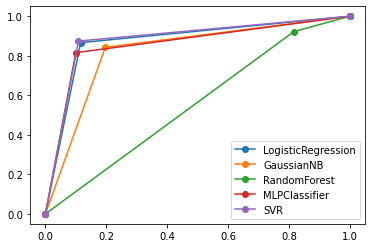

,Model Name,Train Accuracy,Test Accuracy,Precision,AUC,Recall,Time
4,LinearSVC,0.8829,0.8829,0.889642,0.882938,0.874467,0.110217
0,LogisticRegressionCV,0.8753,0.8753,0.882225,0.875338,0.866471,16.728259
3,MLPClassifier,0.8579,0.8579,0.891089,0.857889,0.815565,10.844640
1,GaussianNB,0.8231,0.8231,0.810977,0.823056,0.842751,0.447802
2,RandomForestClassifier,0.5532,0.5532,0.530756,0.553003,0.922175,0.100703


In [52]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
model_name=["LogisticRegression","GaussianNB","RandomForest","MLPClassifier","SVR"]
row_index = 0
for model,name in zip(MLA,model_name):
    start = time.time()
    predicted = model.fit(train_x_tfidf, train_y).predict(test_x_tfidf)
    fp, tp, th = roc_curve(test_y, predicted)
    cost_time=(time.time() - start)
    plt.plot(fp,tp,marker = 'o',label = name)
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(model.score(train_x_tfidf, train_y), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(model.score(test_x_tfidf, test_y), 4)
    MLA_compare.loc[row_index, 'Precision'] = precision_score(test_y, predicted)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)
    MLA_compare.loc[row_index, 'Recall'] = recall_score(test_y, predicted)
    MLA_compare.loc[row_index, 'Time'] = cost_time
  
    row_index+=1
plt.legend()
plt.show()
MLA_compare.sort_values(by = ['AUC'], ascending = False, inplace = True)

MLA_compare

# SVM performance evaluation

In [53]:
model=svm.LinearSVC()
model.fit(train_x_tfidf, train_y)
svmEvaPred=model.predict(eva_x_tfidf)
EvaData.insert(0,"svm_pred",svmEvaPred)


# Bayes performance evaluation

In [54]:
model=naive_bayes.GaussianNB()
model.fit(train_x_tfidf, train_y)
bsEvaPred=model.predict(eva_x_tfidf)
EvaData.insert(0,"bs_pred",bsEvaPred)
EvaData.to_csv("svm_bs_evaluation.csv")